In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkContext
sc = SparkContext("local", "first app")

## import

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time

## CFG

In [4]:
class CFG :
    debug = False
    convergenceTol = 1e-6
    max_iter = 50
    d = 0.85
    N_list = [1000, 2000, 4000, 8000, 16000]

## Help function

In [5]:
def create_setdata(ss) : 
    record = set()
    for i in ss : 
        if i not in record : 
            record.add(i)
        else :
            yield record
            record = set()
    if not record : 
        yield record

In [6]:
def create_dataset(N) : 
    while True : 
        s = np.random.default_rng().zipf(1.2, N * 10 * 10)
        dataset = list(create_setdata(s[s < N]))
        if len(dataset) >= N : 
            break
            
    ids = range(N)
    return [(i, s) for i, s in zip(ids, dataset[:N])]

In [7]:
def make_time(N_list) : 
    time_list = []
    for N in N_list : 
        time_list.append(pagerank(N, CFG.max_iter, CFG.d))
    return time_list

In [8]:
def make_graph(N_list, time_list) : 
    plt.plot(N_list, time_list, 'r^-')
    plt.xlabel("Number of Data")
    plt.ylabel("Processing Time")
    plt.title("Quiz Result")
    plt.tight_layout()
    plt.show()

## Main

In [9]:
def pagerank(N, max_iter, d) : 
    # check time
    start = time.time()
    
    # Broadcast pr
    pr = sc.broadcast([1./float(N) for _ in range(N)])
        
    # make dataset
    dataset = create_dataset(N)
    inputRDD = sc.parallelize(dataset).cache()
        
    for iterNum in range(max_iter) : 
        if CFG.debug == True : 
            print(f"============ {iterNum} ===========")
        
        itr = inputRDD.flatMap(lambda x: [(target, pr.value[x[0]] / len(x[1])) for target in x[1]])
        itr2 = itr.reduceByKey(lambda x, y : x + y)
        itr3 = itr2.mapValues(lambda x : d * x + 1/N * (1-d)).cache()

        # test convergence
        err = itr.map(lambda x : abs(pr.value[x[0]])).sum() / N
        
        if err < CFG.convergenceTol : 
            pr = itr.map(lambda x : x[1]).collect()
            break
        
        # update broadcast pr
        pr = sc.broadcast(itr.map(lambda x : x[1]).collect())
        

        if CFG.debug == True : 
            print("===== err")
            print(err)
            
    if CFG.debug == True :    
        print("============= End ===============")
        
    # return time
    return time.time() - start

## Result

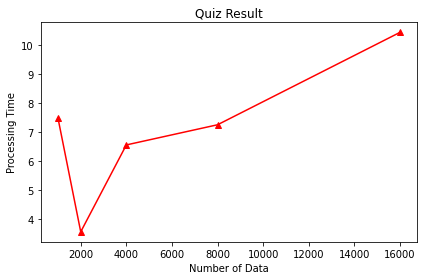

In [10]:
time_list = make_time(CFG.N_list)
make_graph(CFG.N_list, time_list)